In [2]:
import os
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.applications import efficientnet_v2, resnet_v2
import matplotlib.pyplot as plt
import pandas as pd
import cv2

#### Preprocessing

In [3]:
DATA_DIR = "RetinalOCT_Dataset"
PREPROCESSED_DIR = "dataset_clahe"
INPUT_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 8
SEED = 42
EPOCHS = 50
MODEL_DIR = "models"
LOG_DIR = "logs"
USE_CLAHE_PREPROCESS = True
USE_EMA = True
AUTOTUNE = tf.data.AUTOTUNE
PSO_PARTICLES = 20
PSO_ITERS = 150
TTA_STEPS = 5

In [4]:
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

In [5]:
def list_classes(path):
    return sorted([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))])

def apply_clahe_to_folder(src_root, dst_root, size=INPUT_SIZE):
    if os.path.exists(dst_root) and any(os.scandir(dst_root)):
        print(f"CLAHE destination '{dst_root}' exists and not empty. Skipping CLAHE.")
        return
    print("Running CLAHE preprocessing (this may take a while)...")
    os.makedirs(dst_root, exist_ok=True)
    for split in ["train", "val", "test"]:
        src_split = os.path.join(src_root, split)
        dst_split = os.path.join(dst_root, split)
        if not os.path.exists(src_split):
            print(f"Warning: {src_split} not found. Skipping.")
            continue
        for class_name in os.listdir(src_split):
            src_cls = os.path.join(src_split, class_name)
            dst_cls = os.path.join(dst_split, class_name)
            os.makedirs(dst_cls, exist_ok=True)
            for fname in os.listdir(src_cls):
                src_path = os.path.join(src_cls, fname)
                dst_path = os.path.join(dst_cls, fname)
                img = cv2.imread(src_path)
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, size)
                lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
                l, a, b = cv2.split(lab)
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
                cl = clahe.apply(l)
                limg = cv2.merge((cl, a, b))
                out = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
                cv2.imwrite(dst_path, cv2.cvtColor(out, cv2.COLOR_RGB2BGR))
    print("CLAHE preprocessing finished.")

if USE_CLAHE_PREPROCESS:
    apply_clahe_to_folder(DATA_DIR, PREPROCESSED_DIR)
    DATA_DIR_USED = PREPROCESSED_DIR
else:
    DATA_DIR_USED = DATA_DIR

train_root = os.path.join(DATA_DIR_USED, 'train')
if not os.path.exists(train_root):
    raise FileNotFoundError(f"Train directory not found: {train_root}")

classes = list_classes(train_root)
print(f"Detected classes: {classes}")

train_ds = keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR_USED, 'train'),
    image_size=INPUT_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    seed=SEED
)
val_ds = keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR_USED, 'val'),
    image_size=INPUT_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=False
)
test_ds = keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR_USED, 'test'),
    image_size=INPUT_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=False
)

train_ds = train_ds.shuffle(1000, seed=SEED).cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

CLAHE destination 'dataset_clahe' exists and not empty. Skipping CLAHE.
Detected classes: ['AMD', 'CNV', 'CSR', 'DME', 'DR', 'DRUSEN', 'MH', 'NORMAL']
Found 18400 files belonging to 8 classes.
Found 2800 files belonging to 8 classes.
Found 2800 files belonging to 8 classes.


In [6]:
try:
    steps_per_epoch = int(tf.data.experimental.cardinality(train_ds).numpy())
    if steps_per_epoch <= 0:
        steps_per_epoch = None
except Exception:
    steps_per_epoch = None
print(f"steps_per_epoch (estimate): {steps_per_epoch}")

steps_per_epoch (estimate): 575


In [7]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
    layers.RandomContrast(0.12),
], name='data_augmentation')

#### Models

In [8]:
def build_effnet(input_shape=(*INPUT_SIZE,3), num_classes=NUM_CLASSES, fine_tune_at=120):
    try:
        base = efficientnet_v2.EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=input_shape)
        preprocess = efficientnet_v2.preprocess_input
    except Exception:
        base = keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
        preprocess = keras.applications.efficientnet.preprocess_input

    base.trainable = True
    for layer in base.layers[:-fine_tune_at]:
        layer.trainable = False

    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = preprocess(x)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs, name='EffNetV2')
    return model

def build_resnet(input_shape=(*INPUT_SIZE,3), num_classes=NUM_CLASSES, fine_tune_at=80):
    base = resnet_v2.ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)
    preprocess = resnet_v2.preprocess_input

    base.trainable = True
    for layer in base.layers[:-fine_tune_at]:
        layer.trainable = False

    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = preprocess(x)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs, name='ResNet50V2')
    return model

def build_cnn(input_shape=(*INPUT_SIZE,3), num_classes=NUM_CLASSES):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs, name='CNN')
    return model

#### Callbacks

In [9]:
class ExponentialMovingAverageCallback(keras.callbacks.Callback):
    def __init__(self, ema_decay=0.9999):
        super().__init__()
        self.ema_decay = float(ema_decay)
        self.ema_weights = None
        self._backup = None

    def set_model(self, model):
        super().set_model(model)
        self.ema_weights = [w.copy() for w in self.model.get_weights()]

    def on_train_batch_end(self, batch, logs=None):
        weights = self.model.get_weights()
        for i in range(len(weights)):
            if self.ema_weights[i] is None:
                self.ema_weights[i] = weights[i].copy()
            else:
                self.ema_weights[i] = self.ema_decay * self.ema_weights[i] + (1.0 - self.ema_decay) * weights[i]

    def on_train_end(self, logs=None):
        self._backup = self.model.get_weights()
        try:
            self.model.set_weights(self.ema_weights)
        except Exception as e:
            print("Warning: failed to set EMA weights on model:", e)

    def restore(self):
        if self._backup is not None:
            self.model.set_weights(self._backup)

In [10]:
def compile_and_train(model, train_ds, val_ds, model_name, epochs=EPOCHS, base_lr=1e-4, warmup_epochs=0):
    ckpt_dir = os.path.join(MODEL_DIR, model_name)
    os.makedirs(ckpt_dir, exist_ok=True)
    log_dir = os.path.join(LOG_DIR, model_name)
    os.makedirs(log_dir, exist_ok=True)

    if steps_per_epoch is None:
        cnt = 0
        for _ in train_ds:
            cnt += 1
        sperep = max(1, cnt)
    else:
        sperep = steps_per_epoch

    optimizer = keras.optimizers.AdamW(learning_rate=base_lr, weight_decay=1e-5)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(ckpt_dir, f"{model_name}.keras"),
            save_best_only=True, save_weights_only=False, monitor='val_accuracy'
        ),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7),
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
        keras.callbacks.CSVLogger(os.path.join(log_dir, 'history.csv')),
        keras.callbacks.TensorBoard(log_dir=log_dir),
    ]

    ema_cb = None
    if USE_EMA:
        ema_cb = ExponentialMovingAverageCallback(ema_decay=0.9999)
        callbacks.append(ema_cb)

    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)

    if ema_cb is not None:
        print("EMA applied at training end (if available).")

    final_path = os.path.join(ckpt_dir, f"{model_name}_final.keras")
    model.save(final_path)
    print(f"Saved final model to: {final_path}")

    if ema_cb is not None:
        ema_cb.restore()

    return history

#### TTA (Test Time Augmentation)

In [11]:
def predict_with_tta(model, dataset, tta_steps=TTA_STEPS):
    probs = []
    for x_batch, _ in dataset:
        x0 = tf.cast(x_batch, tf.float32)
        batch_probs = np.zeros((x0.shape[0], NUM_CLASSES), dtype=np.float32)
        for _ in range(tta_steps):
            aug = data_augmentation(x0, training=True)
            preds = model.predict(aug, verbose=0)
            batch_probs += preds
        batch_probs /= float(tta_steps)
        probs.append(batch_probs)
    probs = np.vstack(probs)
    return probs

#### Ensemble Types

In [12]:
def ensemble_average(probs_list):
    return np.mean(np.stack(probs_list, axis=0), axis=0)

def ensemble_weighted(probs_list, weights):
    w = np.array(weights).reshape(-1,1,1)
    stacked = np.stack(probs_list, axis=0)
    combined = np.sum(w * stacked, axis=0)
    return combined

class SimplePSO:
    def __init__(self, n_particles, dim, probs_list, y_true, iters=100, w=0.72, c1=1.49, c2=1.49, lb=-1, ub=2):
        self.lb = lb
        self.ub = ub
        self.n_particles = n_particles
        self.dim = dim
        self.probs_list = probs_list
        self.y_true = y_true
        self.iters = iters
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.pos = np.random.uniform(lb, ub, size=(n_particles, dim))
        self.vel = np.zeros_like(self.pos)
        self.pbest_pos = self.pos.copy()
        self.pbest_val = np.array([self._fitness(p) for p in self.pos])
        self.gbest_idx = np.argmin(self.pbest_val)
        self.gbest_pos = self.pbest_pos[self.gbest_idx].copy()
        self.gbest_val = self.pbest_val[self.gbest_idx]

    def _fitness(self, weights):
        combined = np.zeros_like(self.probs_list[0])
        for w, preds in zip(weights, self.probs_list):
            combined += w * preds
        preds = np.argmax(combined, axis=1)
        acc = accuracy_score(self.y_true, preds)
        return -acc

    def optimize(self):
        for it in range(self.iters):
            r1 = np.random.rand(self.n_particles, self.dim)
            r2 = np.random.rand(self.n_particles, self.dim)
            cognitive = self.c1 * r1 * (self.pbest_pos - self.pos)
            social = self.c2 * r2 * (self.gbest_pos - self.pos)
            self.vel = self.w * self.vel + cognitive + social
            self.pos = self.pos + self.vel
            self.pos = np.clip(self.pos, self.lb, self.ub)
            vals = np.array([self._fitness(p) for p in self.pos])
            improved = vals < self.pbest_val
            self.pbest_val[improved] = vals[improved]
            self.pbest_pos[improved] = self.pos[improved]
            gidx = np.argmin(self.pbest_val)
            if self.pbest_val[gidx] < self.gbest_val:
                self.gbest_val = self.pbest_val[gidx]
                self.gbest_pos = self.pbest_pos[gidx].copy()
            if it % max(1, self.iters//10) == 0 or it == self.iters - 1:
                print(f"PSO iter {it+1}/{self.iters}, best_acc = {-self.gbest_val:.4f}")
        return self.gbest_pos, -self.gbest_val

## Main Workflow

In [ ]:
if __name__ == '__main__':

    EFFNET_LOAD_PATH = "models/effnetv2_finetuned/effnetv2_finetuned_final.keras"
    RESNET_LOAD_PATH = "models/resnet50v2_finetuned/resnet50v2_finetuned_final.keras"
    CNN_LOAD_PATH = "models/cnn/cnn_final.keras"

    USE_PRETRAINED = True 

    if USE_PRETRAINED:
        print(">>> Loading pretrained EfficientNetV2...")
        effnet = keras.models.load_model(EFFNET_LOAD_PATH)
        print("Loaded:", EFFNET_LOAD_PATH)

        print(">>> Loading pretrained ResNet50V2...")
        resnet = keras.models.load_model(RESNET_LOAD_PATH)
        print("Loaded:", RESNET_LOAD_PATH)

        print(">>> Loading CNN model...")
        cnn = keras.models.load_model(CNN_LOAD_PATH)
        print("Loaded:", CNN_LOAD_PATH)
    else:
        print("Building models (EffNetV2, ResNet50V2, CNN)")
        effnet = build_effnet(fine_tune_at=120)
        resnet = build_resnet(fine_tune_at=80)
        cnn = build_cnn()

        compile_and_train(effnet, train_ds, val_ds, model_name='effnetv2_finetuned', epochs=EPOCHS, base_lr=1e-4, warmup_epochs=3)
        compile_and_train(resnet, train_ds, val_ds, model_name='resnet50v2_finetuned', epochs=EPOCHS, base_lr=1e-4, warmup_epochs=3)
        compile_and_train(resnet, train_ds, val_ds, model_name='cnn', epochs=EPOCHS, base_lr=1e-4, warmup_epochs=2)

    print(effnet.summary())
    print(resnet.summary())
    print(cnn.summary())

    print("Computing TTA predictions (this may take a while)")
    eff_probs = predict_with_tta(effnet, val_ds, tta_steps=TTA_STEPS)
    res_probs = predict_with_tta(resnet, val_ds, tta_steps=TTA_STEPS)
    cnn_probs = predict_with_tta(cnn, val_ds, tta_steps=TTA_STEPS)

    y_true = np.concatenate([y.numpy() for _, y in val_ds], axis=0)

    avg_probs = ensemble_average([eff_probs, res_probs, cnn_probs])
    avg_pred = np.argmax(avg_probs, axis=1)
    avg_acc = accuracy_score(y_true, avg_pred)
    print(f"Average ensemble accuracy: {avg_acc:.4f}")
    print(classification_report(y_true, avg_pred))

    print("Running PSO to find best ensemble weights...")
    pso = SimplePSO(n_particles=PSO_PARTICLES, dim=3, probs_list=[eff_probs, res_probs, cnn_probs], y_true=y_true, iters=PSO_ITERS)
    best_w, best_acc = pso.optimize()
    print(f"Best weights: {best_w}, best_acc: {best_acc:.4f}")

    combined = ensemble_weighted([eff_probs, res_probs, cnn_probs], best_w)
    comb_pred = np.argmax(combined, axis=1)
    print(classification_report(y_true, comb_pred))

    np.save('ensemble_weights_3models.npy', best_w)
    print("All done. Models and ensemble weights saved.")


>>> Loading pretrained EfficientNetV2...
Loaded: models/effnetv2_finetuned/effnetv2_finetuned_final.keras
>>> Loading pretrained ResNet50V2...
Loaded: models/resnet50v2_finetuned/resnet50v2_finetuned_final.keras
>>> Loading CNN model...
Loaded: models/cnn/cnn_final.keras


Model: "EffNetV2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_35 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_17     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,920,130 (64.55 MB)

 Trainable params: 5,136,564 (19.59 MB)

 Non-trainable params: 1,510,436 (5.76 MB)

 Optimizer params: 10,273,130 (39.19 MB)

None


Model: "ResNet50V2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_38 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_5 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_5 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_18     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,624,090 (250.34 MB)

 Trainable params: 20,498,952 (78.20 MB)

 Non-trainable params: 4,127,232 (15.74 MB)

 Optimizer params: 40,997,906 (156.39 MB)

None


Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 386,778 (1.48 MB)

 Trainable params: 128,776 (503.03 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 257,554 (1006.07 KB)

None
Computing TTA predictions (this may take a while)
Average ensemble accuracy: 0.9550
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       350
           1       0.97      0.90      0.93       350
           2       1.00      1.00      1.00       350
           3       0.94      0.92      0.93       350
           4       1.00      1.00      1.00       350
           5       0.92      0.86      0.89       350
           6       1.00      1.00      1.00       350
           7       0.87      0.97      0.92       350

    accuracy                           0.95      2800
   macro avg       0.96      0.96      0.95      2800
weighted avg       0.96      0.95      0.95      2800

Running PSO to find best ensemble weights...
PSO iter 1/150, best_acc = 0.9607
PSO iter 16/150, best_acc = 0.9607
PSO iter 31/150, best_acc = 0.9607
PSO iter 46/150, best_acc = 0.9607
PSO iter 61/150, best_acc = 0.9607
PSO iter 76/150, best_acc = 0.9607
PSO it

In [ ]:
def evaluate_single_model(model, val_ds, tta_steps=5):
    print(f"\nEvaluating single model: {model.name}")

    probs = predict_with_tta(model, val_ds, tta_steps=tta_steps)

    y_true = np.concatenate([y.numpy() for _, y in val_ds], axis=0)

    preds = np.argmax(probs, axis=1)

    acc = accuracy_score(y_true, preds)
    print(f"Accuracy ({model.name}): {acc:.4f}")

    print(classification_report(y_true, preds, target_names=classes))

    return acc, preds

In [34]:
evaluate_single_model(effnet, val_ds, tta_steps=TTA_STEPS)


Evaluating single model: EffNetV2
Accuracy (EffNetV2): 0.9493
              precision    recall  f1-score   support

         AMD       1.00      1.00      1.00       350
         CNV       0.96      0.86      0.91       350
         CSR       1.00      1.00      1.00       350
         DME       0.92      0.91      0.92       350
          DR       1.00      1.00      1.00       350
      DRUSEN       0.86      0.87      0.86       350
          MH       1.00      1.00      1.00       350
      NORMAL       0.86      0.95      0.90       350

    accuracy                           0.95      2800
   macro avg       0.95      0.95      0.95      2800
weighted avg       0.95      0.95      0.95      2800



(0.9492857142857143, array([0, 0, 0, ..., 7, 7, 7], shape=(2800,)))

In [35]:
evaluate_single_model(resnet, val_ds, tta_steps=TTA_STEPS)


Evaluating single model: ResNet50V2
Accuracy (ResNet50V2): 0.9571
              precision    recall  f1-score   support

         AMD       1.00      1.00      1.00       350
         CNV       0.95      0.91      0.93       350
         CSR       1.00      1.00      1.00       350
         DME       0.94      0.94      0.94       350
          DR       1.00      1.00      1.00       350
      DRUSEN       0.93      0.83      0.88       350
          MH       1.00      1.00      1.00       350
      NORMAL       0.85      0.98      0.91       350

    accuracy                           0.96      2800
   macro avg       0.96      0.96      0.96      2800
weighted avg       0.96      0.96      0.96      2800



(0.9571428571428572, array([0, 0, 0, ..., 7, 7, 7], shape=(2800,)))

In [18]:
evaluate_single_model(cnn, val_ds, tta_steps=TTA_STEPS)


Evaluating single model: CNN
Accuracy (CNN): 0.8707
              precision    recall  f1-score   support

         AMD       1.00      1.00      1.00       350
         CNV       0.84      0.87      0.86       350
         CSR       0.97      0.98      0.98       350
         DME       0.87      0.79      0.83       350
          DR       0.96      0.78      0.86       350
      DRUSEN       0.87      0.67      0.75       350
          MH       0.81      0.95      0.88       350
      NORMAL       0.72      0.92      0.81       350

    accuracy                           0.87      2800
   macro avg       0.88      0.87      0.87      2800
weighted avg       0.88      0.87      0.87      2800



(0.8707142857142857, array([0, 0, 0, ..., 7, 7, 7], shape=(2800,)))

TTA steps = 1
TTA steps = 2
TTA steps = 3
TTA steps = 4
TTA steps = 5
TTA steps = 1
TTA steps = 2
TTA steps = 3
TTA steps = 4
TTA steps = 5
TTA steps = 1
TTA steps = 2
TTA steps = 3
TTA steps = 4
TTA steps = 5


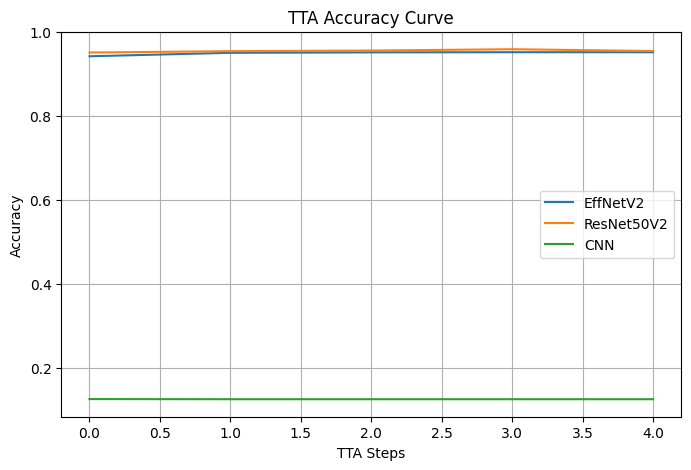

In [20]:
def compute_tta_accuracy(model, val_ds, max_steps=5):
    y_true = np.concatenate([y.numpy() for _, y in val_ds], axis=0)
    accs = []

    for t in range(1, max_steps+1):
        print(f"TTA steps = {t}")
        probs = predict_with_tta(model, val_ds, tta_steps=t)
        preds = np.argmax(probs, axis=1)
        acc = accuracy_score(y_true, preds)
        accs.append(acc)

    return accs

eff_tta_curve = compute_tta_accuracy(effnet, val_ds, max_steps=5)
res_tta_curve = compute_tta_accuracy(resnet, val_ds, max_steps=5)
cnn_tta_curve = compute_tta_accuracy(cnn, val_ds, max_steps=5)

plt.figure(figsize=(8,5))
plt.plot(eff_tta_curve, label="EffNetV2")
plt.plot(res_tta_curve, label="ResNet50V2")
plt.plot(cnn_tta_curve, label="CNN")
plt.xlabel("TTA Steps")
plt.ylabel("Accuracy")
plt.title("TTA Accuracy Curve")
plt.legend()
plt.grid()
plt.show()

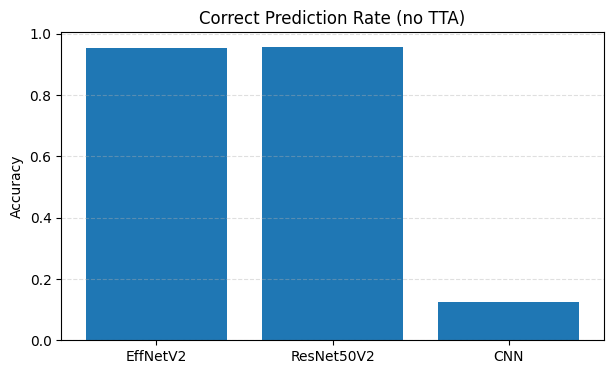

In [21]:
eff_pred = np.argmax(eff_probs, axis=1)
res_pred = np.argmax(res_probs, axis=1)
cnn_pred = np.argmax(cnn_probs, axis=1)

disagreement = np.column_stack([
    eff_pred == y_true,
    res_pred == y_true,
    cnn_pred == y_true
])

plt.figure(figsize=(7,4))
plt.bar(["EffNetV2", "ResNet50V2", "CNN"], disagreement.mean(axis=0))
plt.title("Correct Prediction Rate (no TTA)")
plt.ylabel("Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

In [24]:
def load_history(log_dir, model_name):
    csv_path = os.path.join(log_dir, model_name, "history.csv")
    df = pd.read_csv(csv_path)

    last = df.iloc[-1]

    print(f"\n📘 {model_name.upper()} — Final Epoch Results")
    print(f"Val Accuracy : {last['val_accuracy']:.4f}")
    print(f"Val Loss     : {last['val_loss']:.4f}")

    return df, last['val_accuracy'], last['val_loss']

log_dir = LOG_DIR

eff_hist, eff_acc, eff_loss = load_history(log_dir, "effnetv2_finetuned")
res_hist, res_acc, res_loss = load_history(log_dir, "resnet50v2_finetuned")
cnn_hist, cnn_acc, cnn_loss = load_history(log_dir, "cnn")


📘 EFFNETV2_FINETUNED — Final Epoch Results
Val Accuracy : 0.9564
Val Loss     : 0.1470

📘 RESNET50V2_FINETUNED — Final Epoch Results
Val Accuracy : 0.9646
Val Loss     : 0.1382

📘 CNN — Final Epoch Results
Val Accuracy : 0.7207
Val Loss     : 0.7796


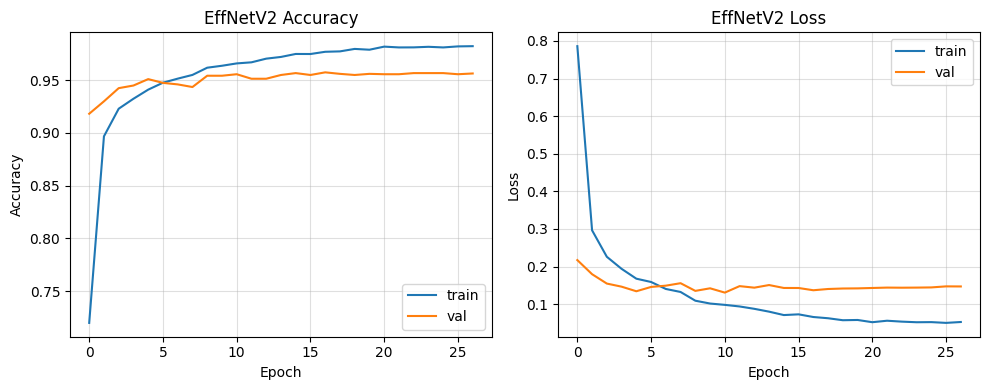

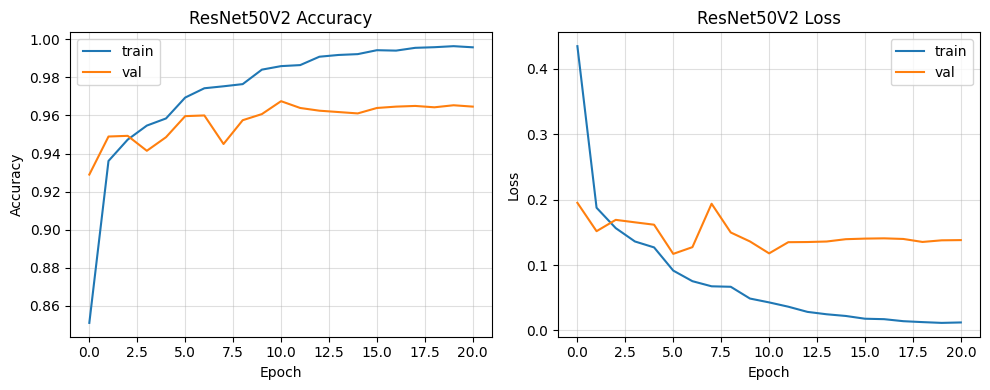

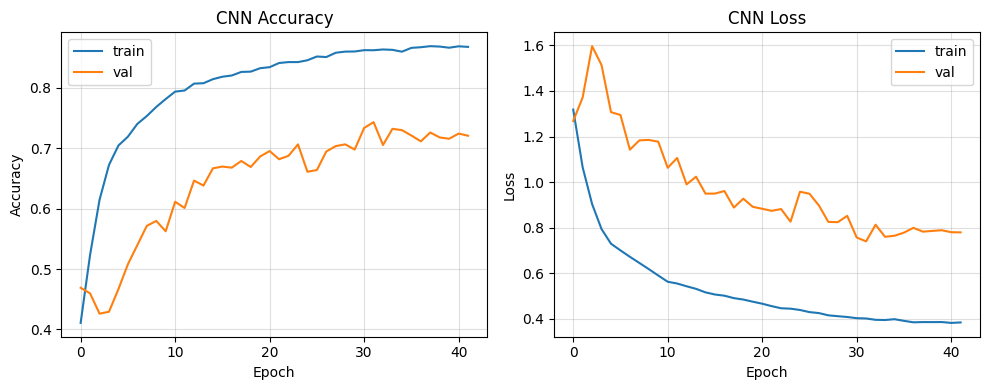

In [25]:
def plot_history(df, model_name):
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.plot(df['accuracy'], label="train")
    plt.plot(df['val_accuracy'], label="val")
    plt.title(f"{model_name} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(alpha=0.4)

    plt.subplot(1,2,2)
    plt.plot(df['loss'], label="train")
    plt.plot(df['val_loss'], label="val")
    plt.title(f"{model_name} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(alpha=0.4)

    plt.tight_layout()
    plt.show()


plot_history(eff_hist, "EffNetV2")
plot_history(res_hist, "ResNet50V2")
plot_history(cnn_hist, "CNN")


In [29]:
eff_test = predict_with_tta(effnet, test_ds, tta_steps=TTA_STEPS)
res_test = predict_with_tta(resnet, test_ds, tta_steps=TTA_STEPS)
cnn_test = predict_with_tta(cnn, test_ds, tta_steps=TTA_STEPS)

best_w = np.load("ensemble_weights_3models.npy")
best_w = best_w / np.sum(best_w)

combined_test = (
    best_w[0] * eff_test +
    best_w[1] * res_test +
    best_w[2] * cnn_test
)

y_true_test = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

y_pred_test = np.argmax(combined_test, axis=1)
test_acc = accuracy_score(y_true_test, y_pred_test)

print(f"\n🔥 Final Test Accuracy (PSO Ensemble): {test_acc:.4f}")
print(classification_report(y_true_test, y_pred_test))

eff_pred = np.argmax(eff_test, axis=1)
res_pred = np.argmax(res_test, axis=1)
cnn_pred = np.argmax(cnn_test, axis=1)

print("EffNet test acc:", accuracy_score(y_true_test, eff_pred))
print("ResNet test acc:", accuracy_score(y_true_test, res_pred))
print("CNN test acc:", accuracy_score(y_true_test, cnn_pred))



🔥 Final Test Accuracy (PSO Ensemble): 0.9607
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       350
           1       0.97      0.88      0.92       350
           2       1.00      1.00      1.00       350
           3       0.94      0.94      0.94       350
           4       1.00      1.00      1.00       350
           5       0.90      0.89      0.89       350
           6       1.00      1.00      1.00       350
           7       0.88      0.98      0.93       350

    accuracy                           0.96      2800
   macro avg       0.96      0.96      0.96      2800
weighted avg       0.96      0.96      0.96      2800

EffNet test acc: 0.9553571428571429
ResNet test acc: 0.9578571428571429
CNN test acc: 0.12535714285714286
